## Setup
You can use the `cover-change` conda environment that is set up already. Or if you want to set up your own environment, follow the steps below.

Create a new conda environment
```
conda create -n cover-change python=3.10 -y 
conda activate cover-change
```
Install the `spatial-utils` project following the description [here](https://github.com/open-forest-observatory/spatial-utils). 

Finally install `scikit-learn`
```
conda install scikit-learn
```

In [10]:
import logging
from pathlib import Path

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import box
import pandas as pd
import pyproj
from sklearn.metrics import ConfusionMatrixDisplay

from spatial_utils.geometric import merge_classified_polygons_by_voting
from spatial_utils.geospatial import ensure_projected_CRS
from spatial_utils.geofileops_wrappers import geofileops_clip, geofileops_dissolve

## Constants

In [11]:
METADATA_FOLDER = Path(
    "/ofo-share/drone-imagery-organization/metadata_backup/3_final/1_full-metadata-per-mission"
)
PREDS_FOLDER = Path(
    "/ofo-share/repos-david/UCNRS-experiments/data/final/post_processed_shifted_predictions_high_conf"
)

ENSURE_NONOVERLAPPING = True
# Quail, BORR, Hastings
RESERVE = "BORR"
ONLY_LEAF_ON = True

# This step is expensive. If False, try to load from disk
COMPUTE_STANDARDIZED = True

CLASS_NAMES = [
    "BE_bare_earth",
    "HL_herbaceous_live",
    "MM_man_made_object",
    "SD_shrub_dead",
    "SL_shrub_live",
    "TD_tree_dead",
    "TL_tree_live",
    "W_water",
]


# Start and end date as month and year (mmdd)
LEAF_ON_START_DATE = 415
LEAF_ON_END_DATE = 1100

logging.basicConfig(level=logging.WARNING)
LAT_LON_CRS = pyproj.CRS.from_epsg(4326)

<Axes: >

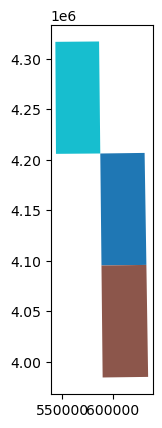

In [12]:
# The generous bounds of the reserves
RESERVE_BOUNDS = gpd.GeoDataFrame(
    {
        "geometry": [
            box(xmin=-122.5, ymin=38, xmax=-122, ymax=39),
            box(xmin=-122, ymin=37, xmax=-121.5, ymax=38),
            box(xmin=-122, ymin=36, xmax=-121.5, ymax=37),
        ],
        "reserve": ["Quail", "BORR", "Hastings"],
    },
    crs=4326,
)
RESERVE_BOUNDS = ensure_projected_CRS(RESERVE_BOUNDS)
RESERVE_BOUNDS.plot("reserve")

In [ ]:
def plot_map(gdf, title=None):
    """Show the map, ensuring that colors are consistent across plots"""
    ax = gdf.plot(
        "class_names", cmap="tab10", vmin=-0.5, vmax=9.5, legend=True, categorical=False, categories=CLASS_NAMES
    )
    if title is not None:
        ax.set_title(title)


def compute_standardized(
    preds: gpd.GeoDataFrame,
    shared_region: gpd.GeoDataFrame,
    reserve: str,
    year: int,
    ensure_nonoverlapping: bool = False,
):
    """
    Crop the predictions to the shared region, merge all instances of the same class, and optional
    remove any overlaps between classes"""
    if len(preds) == 0:
        return None

    # Make sure everything is in a projected CRS
    preds = ensure_projected_CRS(preds)
    # Clip the geometry to the shared region
    print("About to clip")
    clipped = geofileops_clip(preds, shared_region)
    print("Done clipping")
    # Whether we want to ensure no class regions overlap
    if ensure_nonoverlapping:
        print("About to merge by voting")
        subset = merge_classified_polygons_by_voting(clipped, "class_names")
        # Add back the ID column
        subset["class_ID"] = [CLASS_NAMES.index(c) for c in subset["class_names"].to_list()]
        # The class names are dropped in this process, so add them back in
        print("Done merging")
    else:
        # Dissolve all instances of the same class across all predicted datasets
        subset = geofileops_dissolve(
            clipped, groupby_columns="class_names", retain_all_columns=True
        )

    # Plot and save visualization
    plot_map(subset, title=f"{year}: after clipping")
    plt.savefig(Path(f"../../data/vis/final_cover_{reserve}_{year}.png"))

    # Clean up the geometry
    subset.geometry = subset.buffer(0)
    # Compute the area fraction
    total_area = (
        gpd.GeoDataFrame(data={"geometry": shared_region})
        .to_crs(subset.crs)
        .area.values[0]
    )

    subset["area_fraction"] = subset.area / total_area
    # Save the standardized data
    subset.to_file(Path(f"../../data/vis/final_cover_{reserve}_{year}.gpkg"))

    return subset


def compute_transition_matrix(
    first_class_df, second_class_df, reserve, first_year=None, second_year=None
):
    overlay = first_class_df.overlay(second_class_df)

    # Get the classes for the left and right dataframes
    i_inds = overlay["class_ID_1"].to_numpy().astype(int)
    j_inds = overlay["class_ID_2"].to_numpy().astype(int)
    # Get the areas of the overlaps
    values = overlay.area.to_numpy()

    # Build a matrix to populate
    transition_matrix = np.zeros((8, 8))
    transition_matrix[i_inds, j_inds] = values
    transition_matrix_row_normed = transition_matrix / np.expand_dims(
        transition_matrix.sum(axis=1), axis=1
    )

    # Compute the years from the dataframes if not provided
    if first_year is None:
        first_year = (
            first_class_df["earliest_datetime_local_derived"]
            .dt.strftime("%Y")
            .astype(int)[0]
        )
    if second_year is None:
        second_year = (
            second_class_df["earliest_datetime_local_derived"]
            .dt.strftime("%Y")
            .astype(int)[0]
        )

    # Display the results
    ConfusionMatrixDisplay(transition_matrix, display_labels=CLASS_NAMES).plot()
    plt.title(f"Transition matrix for {reserve} for {first_year}-{second_year}")
    plt.xticks(rotation=70)
    plt.savefig(
        Path(f"../../data/vis/transition_{reserve}_{first_year}_{second_year}.png")
    )
    plt.show()
    # Show the results with each row normalized to a sum of one
    ConfusionMatrixDisplay(
        transition_matrix_row_normed, display_labels=CLASS_NAMES
    ).plot()
    plt.title(
        f"Transition matrix (row-normalized) for {reserve} for {first_year}-{second_year}"
    )
    plt.xticks(rotation=70)
    plt.savefig(
        Path(
            f"../../data/vis/transition_normalized_{reserve}_{first_year}_{second_year}.png"
        )
    )
    plt.show()

# Load predictions
The geospatial predictions for each dataset are saved individually to disk. Load them and concatenate them into a dataframe. Additionally record which dataset each prediction came from.

,class_ID,class_names,geometry,mission_id,earliest_datetime_local_derived
0,7,W_water,"MULTIPOLYGON (((612269.623 4137728.511, 612271...",000479,2020-02-20 18:22:59
1,2,MM_man_made_object,"MULTIPOLYGON (((611831.11 4137998.865, 611833....",000479,2020-02-20 18:22:59
2,4,SL_shrub_live,"MULTIPOLYGON (((612947.347 4138603.917, 612947...",000479,2020-02-20 18:22:59
3,6,TL_tree_live,"MULTIPOLYGON (((613121.05 4136758.826, 613121....",000479,2020-02-20 18:22:59
4,1,HL_herbaceous_live,"MULTIPOLYGON (((613011.385 4138429.361, 613011...",000479,2020-02-20 18:22:59
...,...,...,...,...,...
4,6,TL_tree_live,"MULTIPOLYGON (((613293.4 4139372.35, 613294.1 ...",001336,2020-09-23 02:11:03
0,0,BE_bare_earth,"MULTIPOLYGON (((612753.95 4139159.75, 612753.5...",001337,2020-09-22 12:47:05
1,2,MM_man_made_object,"MULTIPOLYGON (((612963 4139197.05, 612963.1 41...",001337,2020-09-22 12:47:05
2,5,TD_tree_dead,"MULTIPOLYGON (((613393.3 4139202.3, 613392.6 4...",001337,2020-09-22 12:47:05


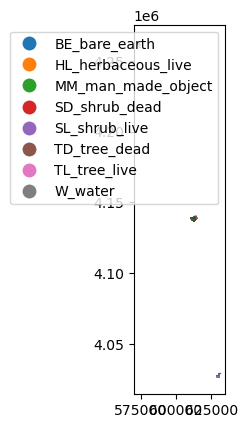

In [14]:
# Find all predicted maps in the folder
pred_files = sorted(PREDS_FOLDER.glob("*"))

preds = []
for pred_file in pred_files:
    metadata_file = Path(METADATA_FOLDER, pred_file.stem + "_mission-metadata.gpkg")
    try:
        metadata = gpd.read_file(metadata_file)
    except:
        print(f"No metadata found for {metadata_file}")
        continue
    # Load the predicted map for one dataset
    pred = gpd.read_file(pred_file)
    # Add the mission ID information so it's tracked in the future
    pred["mission_id"] = pred_file.stem
    pred["earliest_datetime_local_derived"] = pd.to_datetime(
        metadata["earliest_datetime_local_derived"].values[0]
    )

    preds.append(pred)

all_preds = pd.concat(preds)
# All the preds are in lat-lon. Convert to a more appropriate CRS for geometric operations.
all_preds = ensure_projected_CRS(all_preds)
# Convert the class_ID field from float to int
all_preds["class_ID"] = all_preds["class_ID"].astype(int)
plot_map(all_preds)
display(all_preds)

# Add additional information
Record which reserve each dataset is from. also, remove datasets that are captured during leaf-off periods if requested.

In [15]:
# Restrict to the time period that leaves would be one
if ONLY_LEAF_ON:
    # Extract the mmdd representation of the month and day
    int_month_day = (
        all_preds["earliest_datetime_local_derived"].dt.strftime("%m%d").astype(int)
    )

    index = (int_month_day > LEAF_ON_START_DATE) & (int_month_day < LEAF_ON_END_DATE)

    print(f"{len(index) - index.sum()} rows dropped")
    all_preds = all_preds[index]

# Add the information about which reserve it corresponds to
all_preds = gpd.sjoin(all_preds, RESERVE_BOUNDS, how="left", predicate="intersects")

166 rows dropped


Subset to a single reserve

In [16]:
# Select data only from one reserve if requested
if RESERVE is not None:
    reserve_preds = all_preds[all_preds["reserve"] == RESERVE]
else:
    reserve_preds = all_preds

Split by year

In [17]:
year = reserve_preds["earliest_datetime_local_derived"].dt.year

preds_2020 = reserve_preds[year == 2020]
preds_2023 = reserve_preds[year == 2023]
preds_2024 = reserve_preds[year == 2024]
print(
    f"There are {preds_2020['mission_id'].unique()} from 2020, {preds_2023['mission_id'].unique()} from 2023, and {preds_2024['mission_id'].unique()} from 2024"
)

There are ['000546' '000547' '000548' '000549' '000551' '000555' '000558' '000559'
 '000563' '001336' '001337'] from 2020, ['000610' '000611' '000612' '000613'] from 2023, and [] from 2024


Compute the shared region across non-empty reserves

<Axes: >

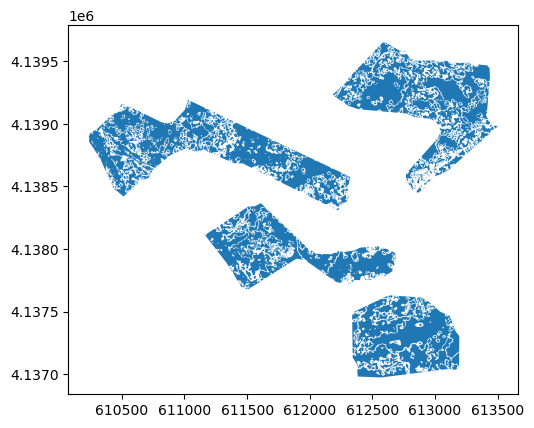

In [18]:
boundary_2020 = preds_2020.dissolve()
boundary_2023 = preds_2023.dissolve()
boundary_2024 = preds_2024.dissolve()

# We do some extra work to make this robust to years that have no data and exclude them from the calculation of the intersection
# Compute the union of all the reserves
shared_region = pd.concat((boundary_2020, boundary_2023, boundary_2024)).dissolve()

if len(boundary_2020) > 0:
    shared_region = shared_region.intersection(boundary_2020)
if len(boundary_2023) > 0:
    shared_region = shared_region.intersection(boundary_2023)
if len(boundary_2024) > 0:
    shared_region = shared_region.intersection(boundary_2024)

shared_region.plot()

## Standardize the predictions

About to clip


Done clipping
About to merge by voting


/home/exouser/miniconda3/envs/cover-change/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Done merging
About to clip
Done clipping
About to merge by voting


/home/exouser/miniconda3/envs/cover-change/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Done merging


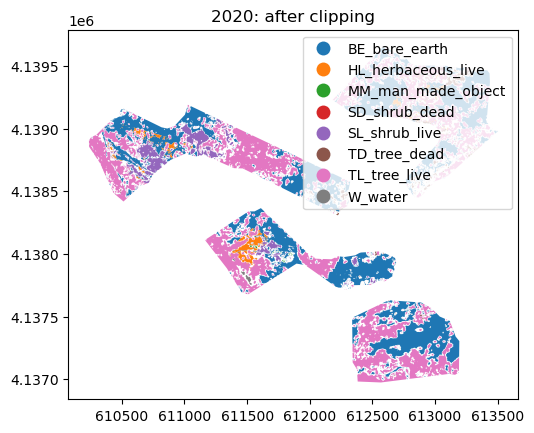

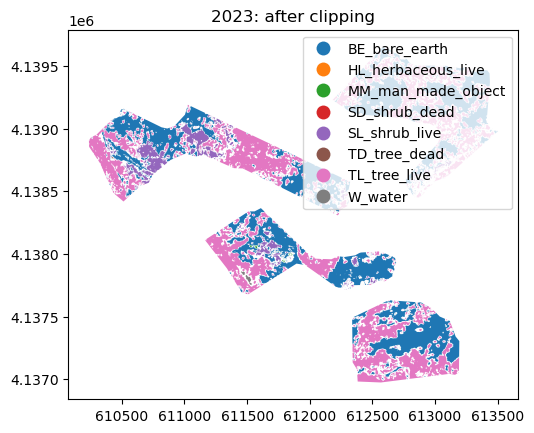

In [19]:
if COMPUTE_STANDARDIZED:
    standardized_2020 = compute_standardized(
        preds_2020,
        shared_region,
        reserve=RESERVE,
        year="2020",
        ensure_nonoverlapping=ENSURE_NONOVERLAPPING,
    )
    standardized_2023 = compute_standardized(
        preds_2023,
        shared_region,
        reserve=RESERVE,
        year="2023",
        ensure_nonoverlapping=ENSURE_NONOVERLAPPING,
    )
    standardized_2024 = compute_standardized(
        preds_2024,
        shared_region,
        reserve=RESERVE,
        year="2024",
        ensure_nonoverlapping=ENSURE_NONOVERLAPPING,
    )
else:
    # Else reload the data
    standardized_2020 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2020.gpkg")
    standardized_2023 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2023.gpkg")
    standardized_2024 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2024.gpkg")

Make a table to summarize the class fractions per

In [22]:
final_table = np.zeros((8, 3))

if standardized_2020 is not None:
    final_table[standardized_2020["class_ID"].to_numpy(), 0] = standardized_2020[
        "area_fraction"
    ]
if standardized_2023 is not None:
    final_table[standardized_2023["class_ID"].to_numpy(), 1] = standardized_2023[
        "area_fraction"
    ]
if standardized_2024 is not None:
    final_table[standardized_2024["class_ID"].to_numpy(), 2] = standardized_2024[
        "area_fraction"
    ]

final_table_vis = pd.DataFrame(
    data=final_table, columns=["2020", "2023", "2024"], index=CLASS_NAMES
)
final_table_vis

,2020,2023,2024
BE_bare_earth,4.858974e-01,0.500102,0.0
HL_herbaceous_live,2.516275e-02,0.000001,0.0
MM_man_made_object,5.118774e-04,0.000484,0.0
SD_shrub_dead,8.631480e-07,0.000000,0.0
SL_shrub_live,4.721420e-02,0.057032,0.0
TD_tree_dead,1.352143e-02,0.000193,0.0
TL_tree_live,4.266771e-01,0.440961,0.0
W_water,1.340339e-03,0.001227,0.0


/home/exouser/miniconda3/envs/cover-change/lib/python3.10/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 7332 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


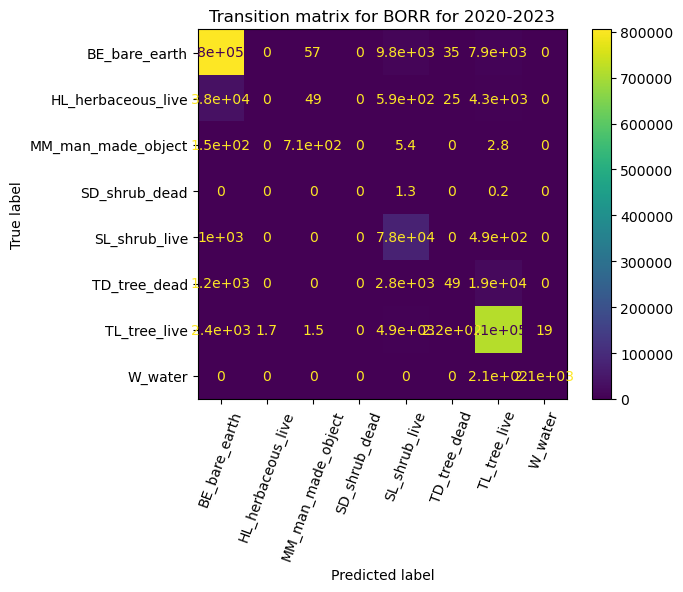

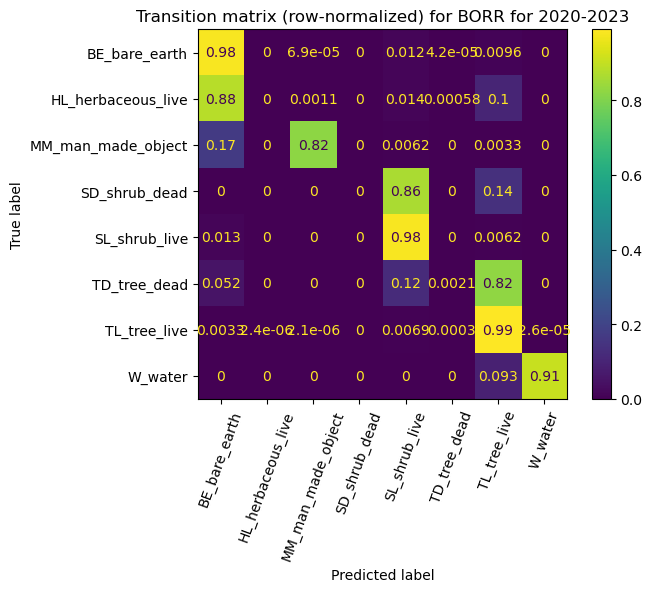

In [23]:
if standardized_2020 is not None and standardized_2023 is not None:
    compute_transition_matrix(
        standardized_2020,
        standardized_2023,
        reserve=RESERVE,
        first_year="2020",
        second_year="2023",
    )

if standardized_2020 is not None and standardized_2024 is not None:
    compute_transition_matrix(
        standardized_2020,
        standardized_2024,
        reserve=RESERVE,
        first_year="2020",
        second_year="2024",
    )

if standardized_2023 is not None and standardized_2024 is not None:
    compute_transition_matrix(
        standardized_2023,
        standardized_2024,
        reserve=RESERVE,
        first_year="2023",
        second_year="2024",
    )

# Merged 2023-2024

This section repeats the last few steps of the previous section but after merging the 2023 and 2024 years since they both occured after significant regrowth

<Axes: >

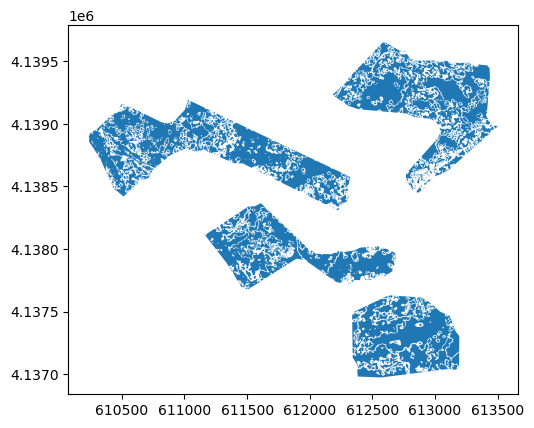

In [24]:
preds_2023_2024 = pd.concat([preds_2023, preds_2024])

boundary_2020 = preds_2020.dissolve()
boundary_2023_2024 = preds_2023_2024.dissolve()

# We do some extra work to make this robust to years that have no data and exclude them from the calculation of the intersection
# Compute the union of all the reserves
shared_region = pd.concat((boundary_2020, boundary_2023_2024)).dissolve()

if len(boundary_2020) > 0:
    shared_region = shared_region.intersection(boundary_2020)
if len(boundary_2023_2024) > 0:
    shared_region = shared_region.intersection(boundary_2023_2024)

shared_region.plot()

About to clip
Done clipping
About to merge by voting


/home/exouser/miniconda3/envs/cover-change/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Done merging
About to clip
Done clipping
About to merge by voting


/home/exouser/miniconda3/envs/cover-change/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Done merging


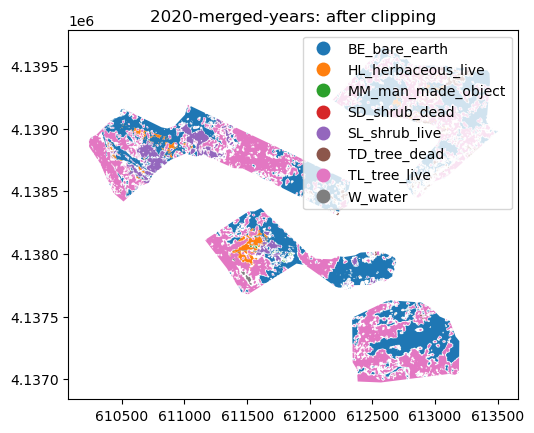

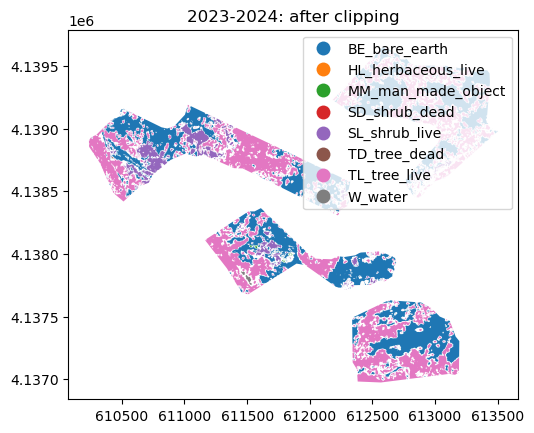

In [25]:
standardized_2020 = compute_standardized(
    preds_2020,
    shared_region,
    reserve=RESERVE,
    year="2020-merged-years",
    ensure_nonoverlapping=ENSURE_NONOVERLAPPING,
)
standardized_2023_2024 = compute_standardized(
    preds_2023_2024,
    shared_region,
    reserve=RESERVE,
    year="2023-2024",
    ensure_nonoverlapping=ENSURE_NONOVERLAPPING,
)

In [26]:
# standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
# standardized_2020.query("class_names == 'BE_bare_earth'")["geometry"]

In [27]:
final_table = np.zeros((8, 2))

if standardized_2020 is not None:
    final_table[standardized_2020["class_ID"], 0] = (
        standardized_2020["area_fraction"]
    )
if standardized_2023_2024 is not None:
    final_table[standardized_2023_2024["class_ID"], 1] = (
        standardized_2023_2024["area_fraction"]
    )

final_table_vis = pd.DataFrame(
    data=final_table, columns=["2020", "2023-2024"], index=CLASS_NAMES
)
final_table_vis

,2020,2023-2024
BE_bare_earth,4.858974e-01,0.500102
HL_herbaceous_live,2.516275e-02,0.000001
MM_man_made_object,5.118774e-04,0.000484
SD_shrub_dead,8.631480e-07,0.000000
SL_shrub_live,4.721420e-02,0.057032
TD_tree_dead,1.352143e-02,0.000193
TL_tree_live,4.266771e-01,0.440961
W_water,1.340339e-03,0.001227


/home/exouser/miniconda3/envs/cover-change/lib/python3.10/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 7332 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


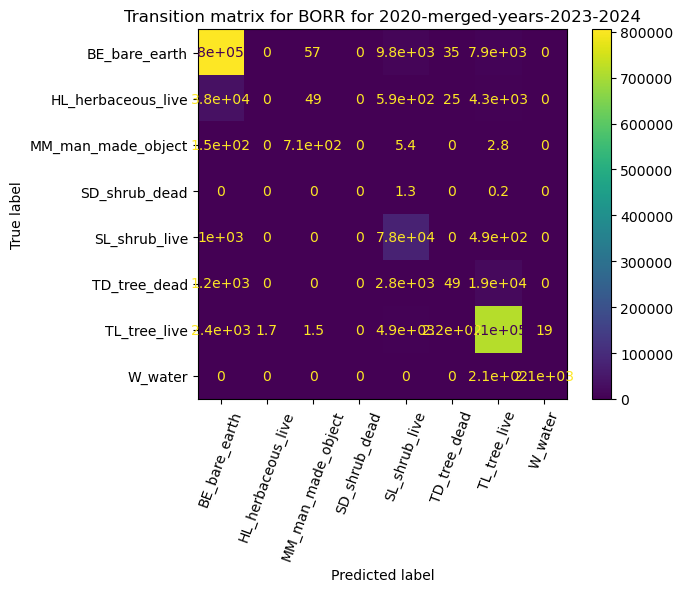

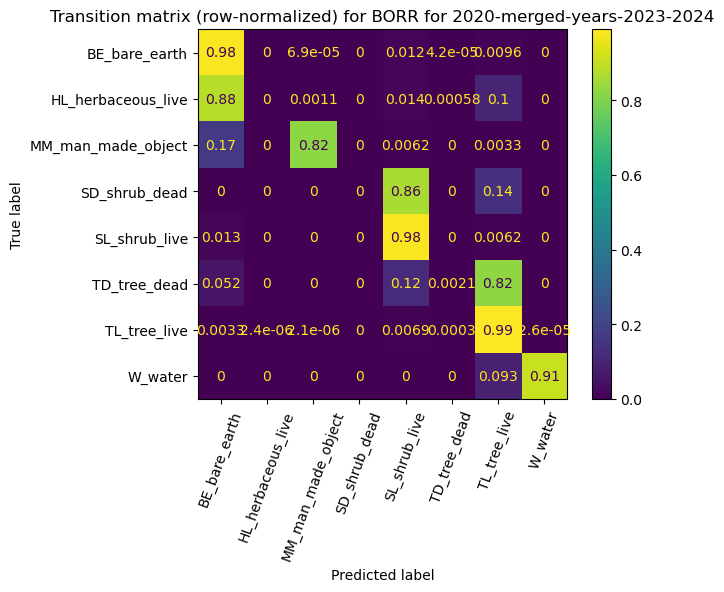

In [28]:
if standardized_2020 is not None and standardized_2023_2024 is not None:
    compute_transition_matrix(
        standardized_2020,
        standardized_2023_2024,
        reserve=RESERVE,
        first_year="2020-merged-years",
        second_year="2023-2024",
    )